In [ ]:
"""notes
   given - alice in wonderland 
    chosen languages english and tamil
    problem - fictional books have diverse vocabulary , we have classified the data for understanding purposes as 
classify the data into categories like (
1. Archaic and Formal Terms ( Words reflecting Victorian-era language and etiquette:)
2. Emotional and Behavioral States (Terms describing mood, demeanor, or psychological conditions )
3. Invented and Nonsensical Words (Coined or playful terms central to the book’s absurdity:)
4. Everyday Objects with Fantastical Twists (Familiar items reimagined in surreal contexts:)
5. Legal and Political Lexicon (Terms tied to authority, justice, and power dynamics:)
)
    now , we can see it has unique words in greater extent in these types of books 
    the rarity of words is a major issue for oov (i.e out of vocabulary) problem
    in order to avoid that and since its a combination of tamil also , find recurring patterns from raw text , cross lingual  - we use BPE algorithm

    citations : 
    https://direct.mit.edu/coli/article/49/4/943/116635/Languages-Through-the-Looking-Glass-of-BPE - BPE's ability to discover recurring patterns in raw text—such as morphological affixes or common syllables—translates across languages, making it effective for both morphologically rich and poor languages.
    
    TRAINING MULTILINGUAL PRE-TRAINED LANGUAGE MODELS
    WITH BYTE-LEVEL SUBWORDS
    TECHNICAL REPORT
    Junqiu Wei, Qun Liu, Yinpeng Guo, Xin Jiang - paper 
"""

In [ ]:
pip install sentencepiece

In [2]:
import sentencepiece as spm
import matplotlib.pyplot as plt
from collections import Counter
import unicodedata
import re

def clean_text(text, language='en'):
    if language == 'en':
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
    else:
        # Tamil Unicode normalization and cleaning
        text = unicodedata.normalize('NFC', text) #example  : ப (Pa) + ெ (Vowel Sign E)	பெ (Single Unit) ( if not normalized)
        text = re.sub(r'[a-zA-Z0-9]', '', text)
        text = re.sub(r'[^\u0B80-\u0BFF\s]', '', text)
    return text

def process_language(filename, lang_code, vocab_size=2000):
    # 1. Preprocessing
    with open(filename, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    
    clean = clean_text(raw_text, lang_code)
    clean_file = f"{lang_code}_clean.txt"
    with open(clean_file, 'w', encoding='utf-8') as f:
        f.write(clean)

    # 2. BPE Vocabulary Construction
    model_prefix = f"{lang_code}_bpe"
    spm.SentencePieceTrainer.train(
        input=clean_file, model_prefix=model_prefix, 
        vocab_size=vocab_size, model_type='bpe'
    )
    
    # 3. Frequency Analysis
    sp = spm.SentencePieceProcessor(model_file=f"{model_prefix}.model")
    tokens = sp.encode_as_pieces(clean)
    freq_dist = Counter(tokens)
    
    return tokens, freq_dist, len(set(tokens))

# Execute for both
en_tokens, en_freq, en_vocab_size = process_language('alice_in_wonderland_eng.txt', 'en')
ta_tokens, ta_freq, ta_vocab_size = process_language('alice_in_wonderland_tamil.txt', 'ta')

# Print Statistics
print(f"--- Statistics ---")
print(f"English - Total Tokens: {len(en_tokens)}, Unique Vocabulary: {en_vocab_size}")
print(f"Tamil   - Total Tokens: {len(ta_tokens)}, Unique Vocabulary: {ta_vocab_size}")

--- Statistics ---
English - Total Tokens: 9812, Unique Vocabulary: 1576
Tamil   - Total Tokens: 10575, Unique Vocabulary: 1790


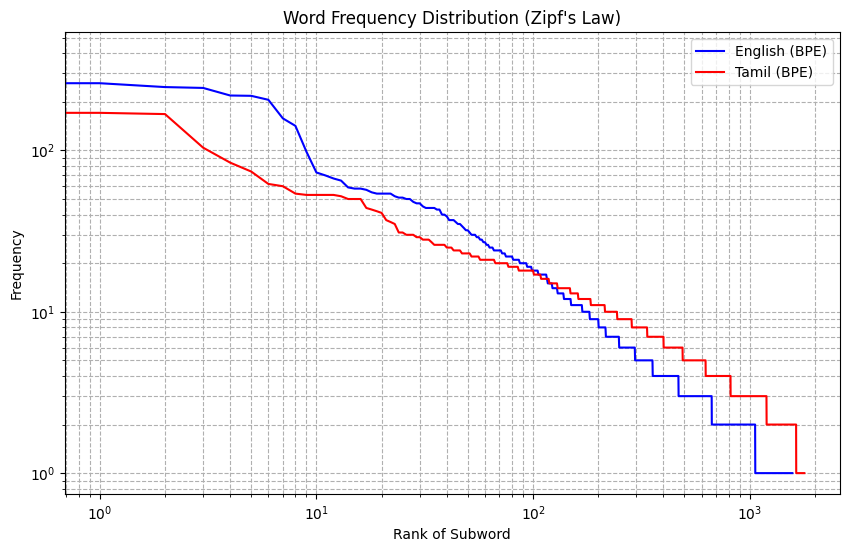

In [3]:
def plot_zipf(freq_dist, label, color):
    counts = sorted(freq_dist.values(), reverse=True)
    plt.loglog(counts, label=label, color=color)

plt.figure(figsize=(10, 6))
plot_zipf(en_freq, "English (BPE)", "blue")
plot_zipf(ta_freq, "Tamil (BPE)", "red")
plt.title("Word Frequency Distribution (Zipf's Law)")
plt.xlabel("Rank of Subword")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
pip install pandas


In [4]:
import pandas as pd
from collections import Counter
import math

def calculate_stats(tokens, lang_name):
    # 1. Basic Counts
    total_tokens = len(tokens)
    unique_tokens = len(set(tokens))
    
    # 2. Lexical Diversity (Type-Token Ratio)
    # TTR = (Unique Words / Total Words)
    ttr = unique_tokens / total_tokens if total_tokens > 0 else 0
    
    # 3. Top 10 Distribution
    counts = Counter(tokens)
    top_10 = counts.most_common(10)
    
    # 4. Word Length Calculation (Character level)
    avg_len = sum(len(t) for t in tokens) / total_tokens
    
    print(f"\n=== Vocabulary Statistics: {lang_name} ===")
    print(f"Total Token Count (N)      : {total_tokens}")
    print(f"Unique Vocabulary Size (V) : {unique_tokens}")
    print(f"Lexical Diversity (TTR)    : {ttr:.4f}")
    print(f"Average Token Length       : {avg_len:.2f} chars")
    
    print(f"\nTop 10 Frequent Units:")
    print(f"{'Rank':<5} | {'Unit':<15} | {'Frequency':<10} | {'Percentage':<10}")
    print("-" * 50)
    for i, (word, freq) in enumerate(top_10, 1):
        percentage = (freq / total_tokens) * 100
        print(f"{i:<5} | {word:<15} | {freq:<10} | {percentage:.2f}%")
        
    return counts

# Assuming en_tokens and ta_tokens were generated from the previous BPE step
en_counts = calculate_stats(en_tokens, "English")
ta_counts = calculate_stats(ta_tokens, "Tamil")


=== Vocabulary Statistics: English ===
Total Token Count (N)      : 9812
Unique Vocabulary Size (V) : 1576
Lexical Diversity (TTR)    : 0.1606
Average Token Length       : 4.62 chars

Top 10 Frequent Units:
Rank  | Unit            | Frequency  | Percentage
--------------------------------------------------
1     | ▁the            | 401        | 4.09%
2     | ▁you            | 261        | 2.66%
3     | ▁and            | 247        | 2.52%
4     | ▁alice          | 244        | 2.49%
5     | ▁a              | 219        | 2.23%
6     | ▁to             | 218        | 2.22%
7     | ▁i              | 206        | 2.10%
8     | ▁it             | 158        | 1.61%
9     | ▁of             | 142        | 1.45%
10    | ▁in             | 98         | 1.00%

=== Vocabulary Statistics: Tamil ===
Total Token Count (N)      : 10575
Unique Vocabulary Size (V) : 1790
Lexical Diversity (TTR)    : 0.1693
Average Token Length       : 5.32 chars

Top 10 Frequent Units:
Rank  | Unit            | Frequenc